# EE-559: Practical Session 2

## Introduction

The objective of this session is to continue practicing with tensors, deal with a real data-set, and get a
feeling of how good/bad are the k-nearest neighbor rule and the PCA dimension reduction on MNIST
and CIFAR10.

In [13]:
import torch
from torch import Tensor
import dlc_practical_prologue as prologue
import matplotlib.pyplot as plt

## Nearest neighbor

Write a function that gets a training set and a test sample and returns the label of the training point
the closest to the latter.

More precisely, write:

def nearest_classification(train_input, train_target, x):

where
1. train_input is a 2d float tensor of dimension n * d containing the training vectors,
1. train_target is a 1d long tensor of dimension n containing the training labels,
1. x is 1d float tensor of dimension d containing the test vector,

and the returned value is the class of the train sample closest to x for the L^2 norm.

**Hint**: The function should have no python loop, and may use in particular torch.mean , torch.view ,
torch.pow , torch.sum , and torch.sort or torch.min.

In [11]:
train_input, train_target, test_input, test_target = prologue.load_data()

print('train_input', train_input.size(), 'train_target', train_target.size())
print('test_input', test_input.size(), 'test_target', test_target.size())

* Using MNIST
Processing...
Done!
** Reduce the data-set (use --full for the full thing)
** Use 1000 train and 1000 test samples
train_input torch.Size([1000, 784]) train_target torch.Size([1000])
test_input torch.Size([1000, 784]) test_target torch.Size([1000])


In [15]:
test_tensor = test_input[0]
test_label = test_target[0]

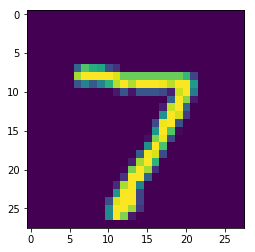

In [18]:
plt.imshow(test_tensor.numpy().reshape(28,28))
plt.show()

In [31]:
def nearest_classification(train_input, train_target, x):
    value, index = torch.min(torch.mean(torch.pow((x - train_input), 2), 1), 0)
   
    return train_target[index].data.tolist()

In [32]:
val= nearest_classification(train_input, train_target, test_tensor)

## Error estimation

Write a function

def compute_nb_errors(train_input, train_target, test_input, test_target, mean = None, proj = None):

where
1. train_input is a 2d float tensor of dimension n × d containing the train vectors,
1. train_target is a 1d long tensor of dimension n containing the train labels,
1. test_input is a 2d float tensor of dimension m × d containing the test vectors,
1. test_target is a 1d long tensor of dimension m containing the test labels,
1. mean is either None or a 1d float tensor of dimension d,
1. proj is either None or a 2d float tensor of dimension c × d ,

that subtracts mean (if it is not None) from the vectors of both train_input and test_input, apply the operator proj (if it is notNone) to both, and returns the number of classification errors using the 1-nearest-neighbor rule on the resulting data.

**Hint**: Use in particular torch.mm .

In [55]:
def compute_nb_errors(train_input, train_target, test_input, test_target, mean = None, 
                      proj = None):
    
    if mean is not None:
        train_input = train_input - mean
        test_input = test_input - mean
    if proj is not None:
        train_input = train_input.mm(torch.transpose(proj, 0, 1))
        test_input = test_input.mm(torch.transpose(proj, 0, 1))
    
    nb_errors = 0
    
    for i in range(test_input.shape[0]):
        if test_target[i].tolist() != nearest_classification(train_input, 
                                                             train_target, test_input[i]):
            nb_errors += 1
    
    print(nb_errors)
    
    return nb_errors

In [36]:
errors = compute_nb_errors(train_input, train_target, test_input, test_target)

172


## PCA

Write a function

def PCA(x):

where x is a 2d float tensor of dimension n × d , which returns a pair composed of the 1d
mean vector of dimension d and the PCA basis, ranked in decreasing order of the eigen-
values, as a 2d tensor of dimension d × d.

**Hint**: The function should have no python loop, and use in particular torch.eig , and torch.sort. 


In [37]:
def PCA(x):
    mean = x.mean(0)
    b = x - mean
    Sigma = b.t().mm(b)
    eigen_values, eigen_vectors = Sigma.eig(True)
    right_order = eigen_values[:,0].abs().sort(0, True)[1]
    eigen_vectors = eigen_vectors.t()[right_order]
    
    return mean, eigen_vectors

## Check that all this makes sense

Compare the performance of the 1-nearest neighbor rule on data projected either a 100d random subspace (i.e. using a basis generated with a normal) and using the PCA basis for
different dimensions (e.g. 3, 10, 50, 100).

Compare also the performance between MNIST and CIFAR. Does all this make sense?

In [51]:
nb_errors = compute_nb_errors(train_input, train_target, test_input, test_target)
print('Baseline nb_errors {:d} error {:.02f}%'.format(nb_errors, 100 * nb_errors / test_input.size(0)))

172
Baseline nb_errors 172 error 17.20%


In [52]:
basis = train_input.new(100, train_input.size(1)).normal_()

In [54]:
basis

tensor([[ 0.0934, -1.0244,  0.6601,  ...,  0.3504, -0.4037,  2.5439],
        [-0.5280,  0.6436,  0.2753,  ...,  0.1433,  0.9295,  0.0826],
        [-0.3237, -0.5254, -1.5891,  ..., -0.8893,  0.3388,  0.6074],
        ...,
        [ 0.9291, -0.1619,  0.3813,  ...,  0.6565, -0.7872, -0.0464],
        [-1.1122,  0.1138, -0.1410,  ...,  0.3476,  1.4485, -2.5771],
        [-1.2628,  2.5255, -1.8213,  ..., -0.2675, -0.7211, -2.6470]])

In [56]:
nb_errors = compute_nb_errors(train_input, train_target, test_input, test_target, None, basis)
print('Random {:d}d nb_errors {:d} error {:.02f}%'.format(basis.size(0), nb_errors, 100 * nb_errors / test_input.size(0)))

198
Random 100d nb_errors 198 error 19.80%


In [57]:
mean, basis = PCA(train_input)

In [59]:
for d in [ 100, 50, 10, 3 ]:
        basis = basis.narrow(0, 0, d)
        nb_errors = compute_nb_errors(train_input, train_target, test_input, test_target, mean, basis)
        print('PCA {:d}d nb_errors {:d} error {:.02f}%'.format(d, nb_errors, 100 * nb_errors / test_input.size(0)))

164
PCA 100d nb_errors 164 error 16.40%
155
PCA 50d nb_errors 155 error 15.50%
214
PCA 10d nb_errors 214 error 21.40%
597
PCA 3d nb_errors 597 error 59.70%
